# 기본 함수 및 라이브러리 로드

In [1]:
# 경고 제어
import warnings
warnings.filterwarnings('ignore')

# 기본 전처리
import numpy as np
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 10000)
pd.options.display.float_format = '{:.4f}'.format

# 시각화
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams['figure.figsize'] = (12, 9)
from scipy.stats import norm

## 필요 함수 로드

In [2]:
def get_object_type(df):
    """ 
    상권코드의 type을 str로 바꿈
    상권_이름을 삭제
    """
    
    df['상권_코드'] = df['상권_코드'].apply(lambda x: str(x))
    try:
        df.drop('상권_이름', inplace=True, axis=1)
    except:
        pass
    return df

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
### Scaler들의 함수를 정의함 ###
def get_Standard(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_MinMaxScaler(df_x):
    m_scaler = MinMaxScaler()
    return m_scaler.fit_transform(np.array(df_x).reshape(-1, 1))

def get_Stan_log1p(df_x):
    s_scaler = StandardScaler()
    return s_scaler.fit_transform(np.array(df_x.agg(np.log1p)).reshape(-1, 1))

def get_log1p(df_x):
    return df_x.agg(np.log1p)

In [4]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

def get_summary(X, y):
    """
    p-value를 체크하는 한다
    """
    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    print(est2.summary())

## 검정 함수

### vif 관련 함수

In [5]:
least = 1000

In [6]:
def get_vif(X, least=100, show=False):
    """
    vif를 구하고 이를 데이터 프레임화
    초기 vif 제한수를 100으로 지정
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    vif = pd.DataFrame()
    vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['features'] = X.columns
    
    if show:
        print(vif, '\n')
        
    vif = vif[vif['features'] != 'const']
    return vif[vif['VIF Factor'] > least]

### AIC 기반 회귀 함수

In [7]:
def processSubset(X, y, feature_set):
    """
    OLS 기반으로 하여 
    모델, AIC 점수, data, Feature들을 출력한다
    
    후에 getBest 함수에서 루프를 타고서
    AIC 점수들을 비교하여 가장 낮은 점수를 출력하는데 도움을 준다
    """
    feature = list(feature_set)
    model = sm.OLS(y, X[feature])
    regr = model.fit()
    AIC = regr.aic
    data = regr.summary()
    
    return {'model': regr, 'AIC': AIC, 'SUMMARY':data, 'Features':feature}

In [8]:
import itertools

def getBest(X, y, k):
    """ 
    k개의 Feature들의 조합 중 가장 낮은 AIC를 가지는 모델을 선택하고 저장하는 함수
    출력물은 model, k개에 맞는 feature, AIC 점수 
    """
    
    results = []           # 결과 저장 공간
    # 절편 컬럼을 제외한 모든 X컬럼의 경우의 수를 조합
    iters = itertools.combinations(X.columns.difference(['const']), k) 
    
    for combo in iters:
        # 상수항을 추가하여 combo를 결성
        combo = (list(combo)+['const'])
        results.append(processSubset(X, y, feature_set = combo)) # 모델링된 것을 저장
        
        # 만약 k=2이면 여기서 두가지 변수만 뽑아서 경우의 수를 분헉하여
        # 저장 후 그중 AIC가 가장 낮은 모델을 선택하도록 함
        
    models = pd.DataFrame(results)     # 데이터 프레임으로 모델결과 반환
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

##### 전진 선택법

In [9]:
def forward(X, y, predictors):
    """
    forward 함수에서는 const를 제외한 모든 feature들을 포함한 AIC 점수를 반환한다.
    predictor는 forward_model에서 정의된 매개변수다.
    forward_model의 predictor에 AIC score를 계산하기 위한 변수들이 저장되며
    그 저장된 변수들을 제외하고서 다시 AIC score를 계산하기 위한 함수
    """
    # predictor - 현재 선택되어 있는 변수
    # 데이터 변수들이 미리 정의된 predictors에 있는지 없는지 확인 및 분류
    
    remaining_predictors = [p for p in X.columns.difference(['const']) if p not in predictors]
    results = []
    for p in remaining_predictors:
        results.append(processSubset(X=X, y=y, feature_set=predictors + [p] + ['const']))
        
    # 데이터 프레임으로 변환
    models = pd.DataFrame(results)
    # AIC가 가장 낮은 것을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
#     print('Processed ', models.shape[0], 'models on', len(predictors)+1)
#     print('Selected predictors:', best_model['model'].model.exog_names, 'AIC: ', best_model[0])
    
    return best_model

def forward_model(X, y):
    """
    전진선택법 모델
    loop를 돌며 forward 함수를 실행시키며 AIC score를 계산하고
    이에 대한 정보를 저장하며 갱신해 나간다.
    loop를 한번 돌때 쓰인 feature들은 predictors에 저장되며 
    이는 forward 함수를 작동할 때 사용되지 않는 용도로 쓰인다.
    """
    Fmodels = pd.DataFrame(columns=['AIC', 'model', 'SUMMARY', 'Features'])
    
    # 미리 정의된 데이터 변수
    # forward에서 AIC를 구할 때 여기에 저장된 변수는 제거하고 계산한다
    predictors = [ ]
    
    for i in range(1, len(X.columns.difference(['const']))+1):
        Forward_result = forward(X, y, predictors)
        if i > 1:
            if Forward_result['AIC'] > Fmodel_before:
                ### AIC 점수가 전의 점수보다 높으면 더이상 loop를 돌지 않고 종료 ###
                break
        Fmodels.loc[i] = Forward_result
        # loop를 돌면서 getBest으로부터(Forward 내부) 계산된 독립변수들이 predictors에 저장됨
        predictors = Fmodels.loc[i]['model'].model.exog_names
        Fmodel_before = Fmodels.loc[i]['AIC']
        ### const를 제외한 변수가 추가된다. ###
        predictors = [ k for k in predictors if k != 'const' ]
    return Fmodels

##### 후진소거법

In [10]:
def backward(X, y, predictors):
    """
    backward_model을 실행하기 위한 선행 함수
    이 함수에서 back_ward의 predictors에 담긴 feature를 토대로 AIC score를 계산하고 저장한다
    
    for문에서 itertools의 combination을 통해 predictors의 숫자 중 -1의 조합으로 가능한 경우의 수를 구한다.
    예) predictors = 6 일때 6C5 => 6개의 경우의 수 도출
    
    for문을 벗어나면 DataFrame에 저장된 AIC score 중 가장 낮은 레코드를 반환함
    """
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors) - 1):
        results.append(processSubset(X, y, feature_set=list(combo) + ['const']))
    models = pd.DataFrame(results)

    # 가장 낮은 AIC를 가진 모델을 선택
    best_model = models.loc[models['AIC'].argmin()]
    
    return best_model

def backward_model(X, y):
    """
    후진소거법
    backward_model은 'const'를 제외한 모든 feature들을 predictors에 저장하고 시작한다.
    AIC를 저장하는 Bmodel_before 변수의 초기값은 'const'를 제외한 모든 feature들을 고려한 AIC 값을 저장하고
    이후 while문을 거치며 새로운 값으로 갱신함
    
    while 문 안에 있는 predictors에서 변수의 갯수를 최신화 하는데
    이는 backward 함수 안에서 feature의 갯수를 하나씩 줄여나간다.
    그리고 backward 함수에서 len(feature) Combination len(featrue)-1 의 경우의 수로 AIC score를 계산함
    
    while문 종료 조건은 2가지로 나눠진다.
    1. 계산된 AIC가 이전 AIC보다 높을 시
    2. 모든 변수를 사용했을시
    """
    Bmodels = pd.DataFrame(columns= ['AIC', 'model', 'SUMMARY', 'Features'], index=range(1, len(X.columns)))
    predictors = X.columns.difference(['const'])
    Bmodel_before = processSubset(X, y, predictors)['AIC']
    
    idx = 1
    while (len(predictors) > 1):
        Backward_result = backward(X, y, predictors)
        
        # loop를 거치고 계산된 AIC가 이전 AIC보다 높으면 loop 종료
        if Backward_result['AIC'] > Bmodel_before:
            break
        
        Bmodels.loc[idx] = Backward_result
        # model에 쓰인 feature들을 최신화 (이후 backward 함수에서 이 저장된 len(feature) combination len(feature)-1로 계산한다)
        # backward 함수에서 feature의 갯수가 하나 줄어든다.
        predictors = Bmodels.loc[idx]['model'].model.exog_names
        Bmodel_before = Backward_result['AIC']
        predictors = [ k for k in predictors if k != 'const' ]
        idx += 1
        
    return Bmodels.dropna()

##### 단계적 선택법

In [11]:
def Stepwise_model(X, y):
    """
    단계적 선택법
    초기 predictors는 X의 모든 Feature, 
    초기 AIC score는 모든 Feature들이 고려된 score로 시작
    
    후에 loop를 돌며 forward, backward 함수를 실행시켜 두 AIC 점수를 비교한다.
    둘 중 작은 AIC 점수를 저장하고 Feature를 최신화한다.
    """
    Stepmodels = pd.DataFrame(columns = ['AIC', 'model', 'SUMMARY', 'Features'])
    predictors = []
    # 모든 Feature들이 고려된 AIC score
    Stepmodels.loc[0] = getBest(X, y, k=1)
    predictors = Stepmodels.loc[0]['model'].model.exog_names
    predictors = [ k for k in predictors if k != 'const' ]
    Smodel_before = Stepmodels.loc[0]['AIC']

    for i in range(2, len(X.columns.difference(['const'])) + 1):
        
        Forward_result = forward(X, y, predictors)
        Backward_result = backward(X, y, predictors)

        
        if Backward_result['AIC'] < Forward_result['AIC']:
            Stepmodels.loc[i] = Backward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
        else:
            Stepmodels.loc[i] = Forward_result
            predictors = Stepmodels.loc[i]['model'].model.exog_names
            predictors = [ k for k in predictors if k != 'const' ]
            
        if Stepmodels.loc[i]['AIC'] > Smodel_before:
            break
        else:
            Smodel_before = Stepmodels.loc[i]['AIC']
            
    return Stepmodels

##### AIC 시각화

In [12]:
def vis_AIC_step(result):
    fig = plt.figure(figsize=(10, 10))
    fig.set_facecolor('white')
    
    font_size = 15
    steps = range(1, result.shape[0]+1)
    AIC = result['AIC'].to_list()
    features = [f'step {i+1}\n' + '\n'.join(s) for i, s in enumerate(result['Features'])]
    
    plt.xticks(steps, features, fontsize=12)
    plt.plot(steps, AIC, marker='o')
    
    plt.ylabel('AIC', fontsize=font_size)
    plt.grid(True)
    plt.show()

### 최적화 함수

In [13]:
def get_best_summary_by_A(model):
    return model.sort_values('AIC').head(1)['SUMMARY'].iloc[0]

def get_best_feature_by_A(model):
    return model.sort_values('AIC').head(1)['Features'].iloc[0]

def get_adj_r_squared_by_A_model(model):
    summary = get_best_summary_by_A(model)
    return float(str(summary).split('Adj. R-squared:')[1].split('Method')[0])

### PCA 함수

In [14]:
from sklearn.decomposition import PCA

def decompo_pca(df, col, new_col):
    
    pca = PCA(n_components=1)
    df[new_col] = pca.fit_transform(pca_df[col])
    df.drop(col, axis=1, inplace=True)
    
    return df

# Data Load

In [15]:
df_i1= pd.read_csv('../data/indicator/preprocess_dev.csv')
df_i1 = df_i1.set_index('상권_코드')
df_i1.head(3)

,점포수,점포_증가량,개업_점포_수,폐업_점포_수,개폐업,개폐업_비율,유흥_총_매출_비율,패션/미용_총_매출_비율,교육_총_매출_비율,요식_총_매출_비율,의료_총_매출_비율,자동차_총_매출_비율,가전/가구/인테리어_총_매출_비율,스포츠관련_총_매출_비율,여행/서비스_총_매출_비율,백화점_총_매출_비율,유통업_총_매출_비율,외식_총_점포수,미용/의류_총_점포수,면적,면적당_점포수,면적당_미용의류_점포수,면적당_외식_점포수,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,목요일_매출_비율,금요일_매출_비율,토요일_매출_비율,일요일_매출_비율,남성_매출_비율,여성_매출_비율,남성_생활인구_비율,여성_생활인구_비율,연령대_10_생활인구_비율,연령대_20_생활인구_비율,연령대_30_생활인구_비율,연령대_40_생활인구_비율,연령대_50_생활인구_비율,연령대_60_이상_생활인구_비율,시간대_1_생활인구_비율,시간대_2_생활인구_비율,시간대_3_생활인구_비율,시간대_4_생활인구_비율,시간대_5_생활인구_비율,시간대_6_생활인구_비율,월요일_생활인구_비율,화요일_생활인구_비율,수요일_생활인구_비율,목요일_생활인구_비율,금요일_생활인구_비율,토요일_생활인구_비율,일요일_생활인구_비율,총_직장_인구_수,남성_직장_인구_수,여성_직장_인구_수,월_평균_소득_금액
상권_코드,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,429,-3,21,13,8,0,0.0040,0.0531,0.0312,0.5751,0.0186,0.0037,0.0086,0.1664,0.0118,0.0000,0.1275,28.0000,12.0000,1.2786,335.5136,9.3850,21.8983,0.1186,0.1315,0.1487,0.1324,0.1545,0.1835,0.1308,0.3869,0.6131,0.5071,0.4929,0.1247,0.1419,0.1921,0.2015,0.1541,0.1856,0.1815,0.2236,0.1706,0.1692,0.1620,0.0931,0.1499,0.1553,0.1534,0.1530,0.1496,0.1226,0.1161,54800,0.7425,0.2575,3528699
1000002,218,-12,3,6,-3,2,0.0138,0.5131,0.0000,0.1175,0.0000,0.0069,0.0681,0.0223,0.0244,0.0000,0.2340,12.0000,11.0000,0.3233,674.3421,34.0264,37.1197,0.1166,0.1164,0.1263,0.1257,0.1568,0.1882,0.1701,0.4013,0.5987,0.5011,0.4989,0.0782,0.1644,0.1907,0.1713,0.1661,0.2294,0.2050,0.2099,0.1542,0.1547,0.1681,0.1082,0.1441,0.1450,0.1451,0.1444,0.1433,0.1391,0.1389,47092,0.5341,0.4659,3283059
1000003,728,-4,11,21,-10,1,0.0285,0.0654,0.5465,0.2218,0.0003,0.0100,0.0120,0.0197,0.0137,0.0000,0.0820,32.0000,10.0000,1.1608,627.1674,8.6149,27.5678,0.1444,0.1443,0.1426,0.1228,0.1432,0.2114,0.0912,0.5792,0.4208,0.5723,0.4277,0.0500,0.1861,0.1873,0.1842,0.1638,0.2286,0.1305,0.1944,0.1893,0.1996,0.2036,0.0826,0.1500,0.1565,0.1557,0.1547,0.1528,0.1258,0.1044,158024,0.6627,0.3373,2909305


In [16]:
df_X = df_i1.copy()
df_y = pd.read_csv('../data/base_data/target.csv', index_col='상권_코드')

# 1차 분석

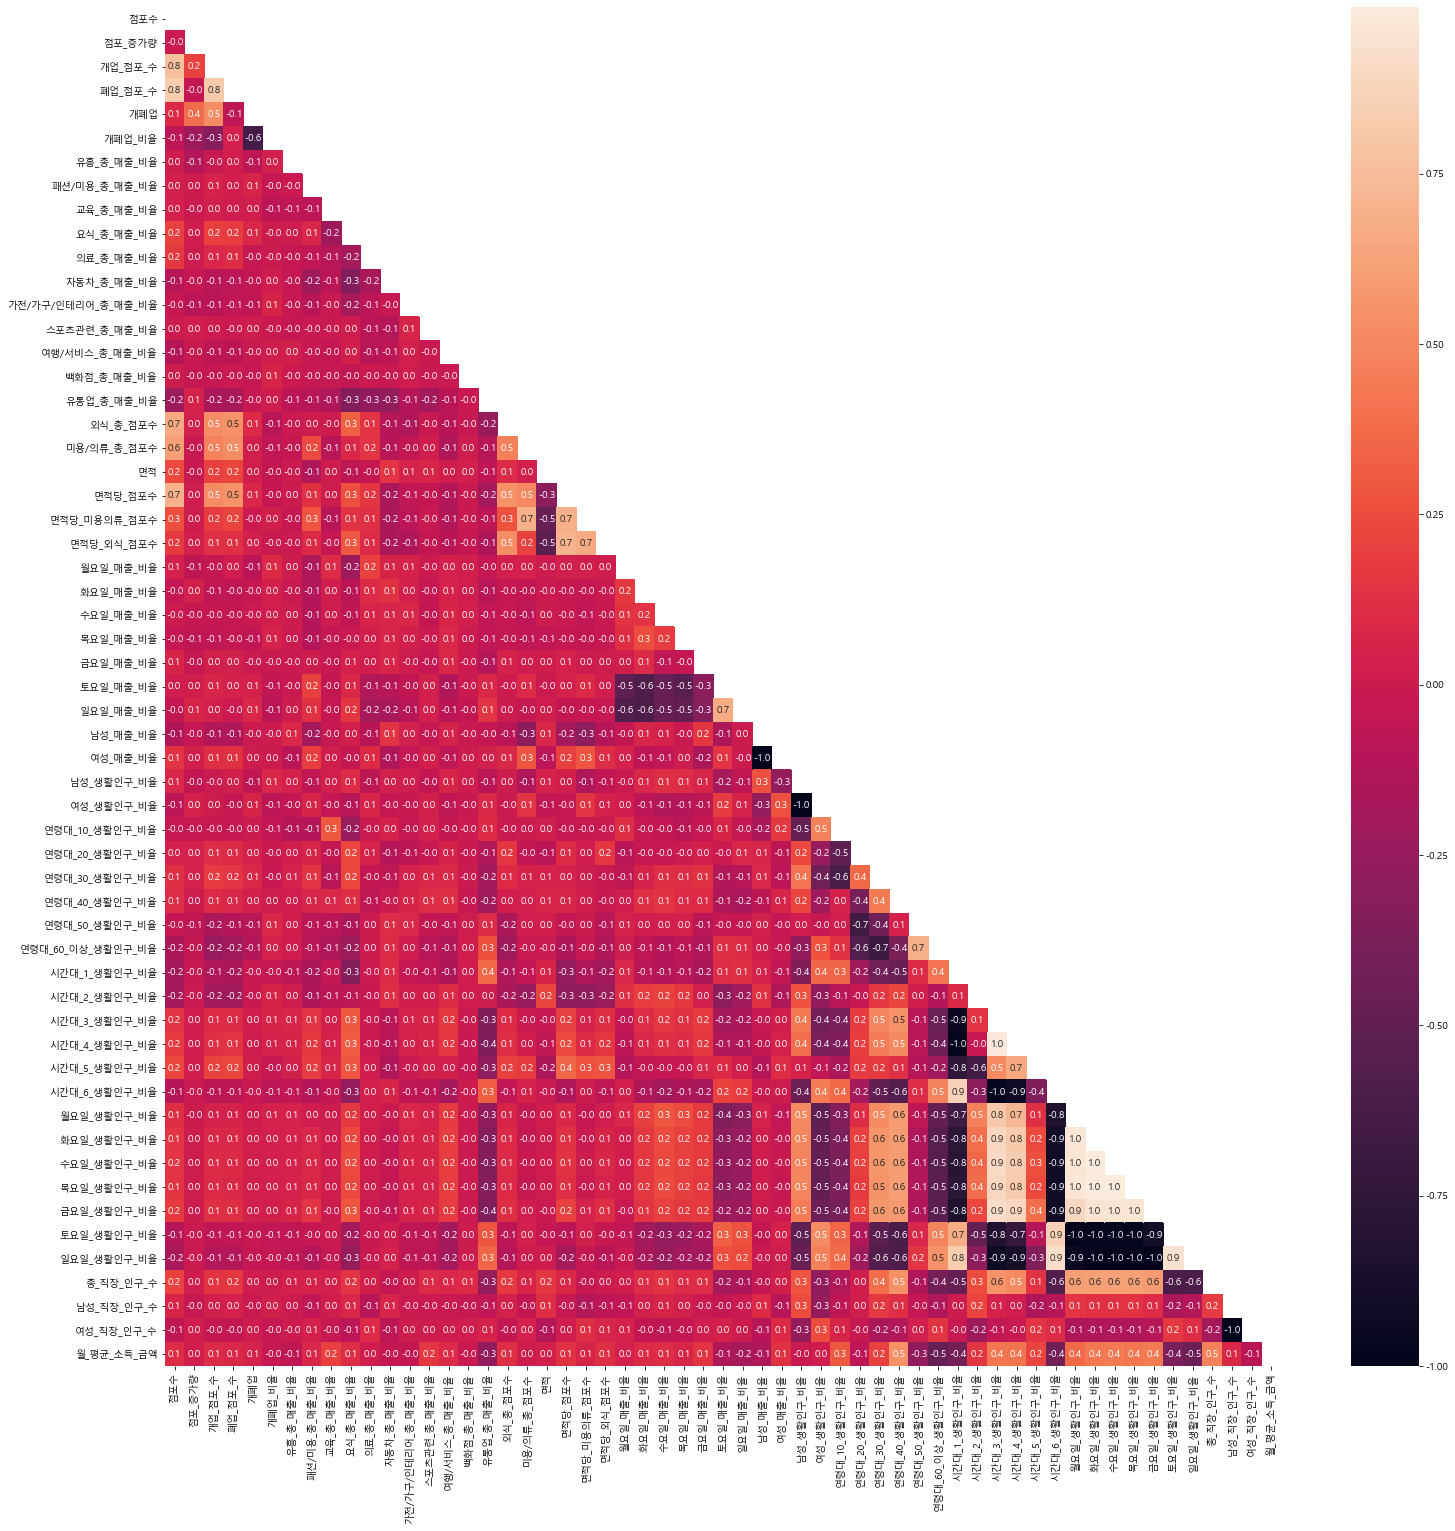

In [17]:
plt.figure(figsize=(25, 25))

mask = np.zeros_like(df_X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_X.corr(), mask=mask, fmt='.1f', annot=True);

In [18]:
model = sm.OLS(df_y, df_X)
regr = model.fit()
data = regr.summary()
data

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 면적당_매출   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     58.63
Date:                Thu, 30 Dec 2021   Prob (F-statistic):          5.73e-259
Time:                        15:04:11   Log-Likelihood:                -14902.
No. Observations:                1009   AIC:                         2.991e+04
Df Residuals:                     956   BIC:                         3.017e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
점포수                  660.9515    336.504      1.964      0.050       0.579    1321.324
점포_증가량              -561.6982   2296.094     -0.245      0.807   -5067.664    3944.268
개업_점포_수             1.316e+05   3.01e+05      0.437      0.662    -4.6e+05    7.23e+05
폐업_점포_수            -1.412e+05   3.01e+05     -0.469      0.639   -7.32e+05     4.5e+05
개폐업                -1.366e+05   3.01e+05     -0.454      0.650   -7.28e+05    4.55e+05
개폐업_비율             -1.042e+04   3.84e+04     -0.271      0.787   -8.59e+04     6.5e+04
유흥_총_매출_비율         -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
패션/미용_총_매출_비율      -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
교육_총_매출_비율         -2.968e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
요식_총_매출_비율         -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
의료_총_매출_비율         -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
자동차_총_매출_비율        -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
가전/가구/인테리어_총_매출_비율 -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
스포츠관련_총_매출_비율      -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
여행/서비스_총_매출_비율     -2.968e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
백화점_총_매출_비율        -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
유통업_총_매출_비율        -2.967e+09   1.28e+10     -0.233      0.816    -2.8e+10    2.21e+10
외식_총_점포수            -1.78e+04   6152.471     -2.893      0.004   -2.99e+04   -5723.277
미용/의류_총_점포수        -8640.4974      1e+04     -0.863      0.388   -2.83e+04     1.1e+04
면적                  2.362e+05   1.14e+05      2.065      0.039    1.17e+04    4.61e+05
면적당_점포수             2146.4723    209.452     10.248      0.000    1735.434    2557.510
면적당_미용의류_점포수        7108.3087   5910.467      1.203      0.229   -4490.679    1.87e+04
면적당_외식_점포수          1.181e+04   3139.886      3.763      0.000    5652.878     1.8e+04
월요일_매출_비율          -4.663e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
화요일_매출_비율          -4.661e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
수요일_매출_비율          -4.663e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
목요일_매출_비율          -4.664e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
금요일_매출_비율          -4.663e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
토요일_매출_비율          -4.665e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
일요일_매출_비율          -4.662e+09      2e+10     -0.233      0.816    -4.4e+10    3.47e+10
남성_매출_비율           -1.632e+10   7.01e+10     -0.233      0.816   -1.54e+11    1.21e+11
여성_매출_비율           -1.632e+10   7.01e+10     -0.233      0.816   -1.54e+11    1.21e+11
남성_생활인구_비율         -3.292e+10    1.5e+

# 1차 Feature Selection
## Stepwise(단계적 선택법)

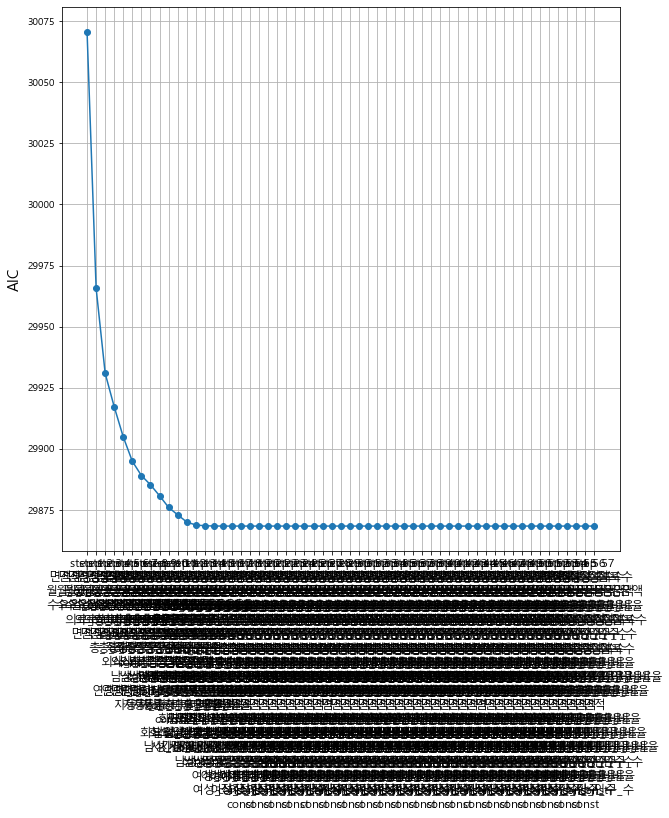

In [19]:
df_X = sm.add_constant(df_X ,has_constant = "add")
s_AIC_model = Stepwise_model(df_X, df_y)
vis_AIC_step(s_AIC_model)

In [20]:
s_best = get_best_summary_by_A(s_AIC_model)
s_best

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 면적당_매출   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     216.7
Date:                Thu, 30 Dec 2021   Prob (F-statistic):          3.97e-290
Time:                        15:04:21   Log-Likelihood:                -14919.
No. Observations:                1009   AIC:                         2.987e+04
Df Residuals:                     994   BIC:                         2.994e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
면적당_점포수         2447.1881     80.641     30.347      0.000    2288.942    2605.434
월_평균_소득_금액         0.1896      0.034      5.548      0.000       0.123       0.257
의료_총_매출_비율      7.433e+05   1.67e+05      4.463      0.000    4.16e+05    1.07e+06
면적당_외식_점포수      1.015e+04   1819.565      5.576      0.000    6574.991    1.37e+04
총_직장_인구_수          2.5853      0.721      3.586      0.000       1.171       4.000
외식_총_점포수       -1.375e+04   3826.200     -3.594      0.000   -2.13e+04   -6243.641
남성_매출_비율       -1.136e+06   2.66e+05     -4.267      0.000   -1.66e+06   -6.13e+05
연령대_30_생활인구_비율  1.794e+06   6.75e+05      2.657      0.008    4.69e+05    3.12e+06
자동차_총_매출_비율     2.715e+05   1.37e+05      1.975      0.049    1782.647    5.41e+05
면적              2.032e+05   9.19e+04      2.212      0.027    2.29e+04    3.83e+05
화요일_매출_비율        1.86e+06   8.17e+05      2.278      0.023    2.58e+05    3.46e+06
남성_생활인구_비율      1.759e+06   1.06e+06      1.662      0.097   -3.18e+05    3.84e+06
시간대_1_생활인구_비율  -1.395e+06   8.28e+05     -1.685      0.092   -3.02e+06     2.3e+05
남성_직장_인구_수       3.52e+05   2.48e+05      1.417      0.157   -1.36e+05     8.4e+05
여성_매출_비율       -2.413e+05   2.21e+05     -1.093      0.274   -6.74e+05    1.92e+05
const          -1.377e+06   4.14e+05     -3.324      0.001   -2.19e+06   -5.64e+05
==============================================================================
Omnibus:                      443.453   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4152.923
Skew:                           1.768   Prob(JB):                         0.00
Kurtosis:                      12.289   Cond. No.                     3.79e+22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.06e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 정규화

In [21]:
from sklearn.preprocessing import MinMaxScaler

col = s_AIC_model.iloc[-1,-1]
df_X = df_X[col]

df_X.to_csv('../data/indicator/fs_dec.csv')

scaler = MinMaxScaler()
cols = df_X.columns
for col in cols:
    df_X[col] = scaler.fit_transform(np.array(df_X[col]).reshape(-1, 1))
    
df_X.describe()

,면적당_점포수,월_평균_소득_금액,의료_총_매출_비율,면적당_외식_점포수,총_직장_인구_수,외식_총_점포수,남성_매출_비율,연령대_30_생활인구_비율,자동차_총_매출_비율,면적,화요일_매출_비율,남성_생활인구_비율,시간대_1_생활인구_비율,남성_직장_인구_수,여성_매출_비율,const
count,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000,1009.0000
mean,0.1176,0.2323,0.1242,0.1153,0.0661,0.5950,0.4865,0.4032,0.1039,0.1691,0.2309,0.2706,0.7080,0.5208,0.5135,0.0000
std,0.0807,0.1651,0.1450,0.0717,0.0977,0.2139,0.1377,0.1762,0.1797,0.0801,0.0793,0.1295,0.1256,0.1240,0.1377,0.0000
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0644,0.1065,0.0280,0.0722,0.0175,0.4444,0.3987,0.2721,0.0035,0.1153,0.1886,0.1839,0.6481,0.4418,0.4214,0.0000
50%,0.1031,0.1888,0.0819,0.1046,0.0322,0.6111,0.4845,0.3739,0.0217,0.1630,0.2222,0.2470,0.7273,0.5144,0.5155,0.0000
75%,0.1524,0.3096,0.1713,0.1395,0.0695,0.7778,0.5786,0.5078,0.0993,0.2088,0.2642,0.3314,0.7939,0.6074,0.6013,0.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000


# 점수 지수화

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

i1_df = pd.DataFrame(columns=['i1_ind1'], index=df_X.index)

lr = LinearRegression()
model = lr.fit(df_X, df_y)
coef = model.coef_.reshape(-1)

scaler = MinMaxScaler()
coef_df = np.array((df_X * coef).sum(axis=1))
i1_indi = scaler.fit_transform(coef_df.reshape(-1, 1)) 
i1_df['i1_ind1'] = i1_indi.reshape(-1)

# 최종 파일 저장

In [23]:
i1_df.head()
i1_df.to_csv('../data/indicator/indicator_i1.csv')
pd.read_csv('../data/indicator/indicator_i1.csv').head()

,상권_코드,i1_ind1
0,1000001,0.1096
1,1000002,0.1617
2,1000003,0.1656
3,1000004,0.1256
4,1000005,0.0598


In [24]:
i1_df['i1_ind1'].sum(axis=0)

127.026611328125